# Spam Classifier

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
# Importing Algorithm
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import pickle

## 1. Data Cleaning

In [2]:
df = pd.read_csv('text.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.rename(columns = {'Category': 'target', 'Message': 'text'}, inplace=True)
df.sample(5)

,target,text
5562,ham,Ok lor... Sony ericsson salesman... I ask shuh...
4944,ham,Check mail.i have mailed varma and kept copy t...
3485,ham,Tell my bad character which u Dnt lik in me. ...
3656,ham,Senthil group company Apnt 5pm.
3689,ham,I'll meet you in the lobby


In [6]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Missing Values
df.isnull().sum()

target    0
text      0
dtype: int64

In [8]:
# Check Duplicate Values
df.duplicated().sum()

415

In [9]:
# Remove Duplicate Values
df = df.drop_duplicates(keep = 'first')

## 2. EDA

In [10]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.target.value_counts()

0    4516
1     641
Name: target, dtype: int64

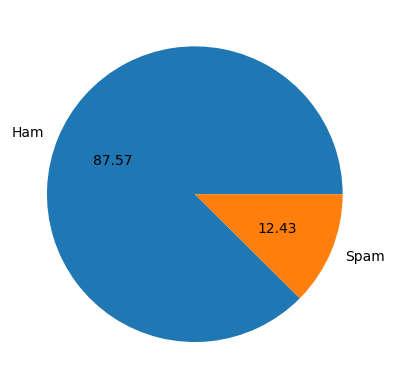

In [12]:
plt.pie(df['target'].value_counts(), labels = ['Ham', 'Spam'], autopct = '%0.2f')
plt.show()

### Data Is In-Balanced

###### Punkt Sentence Tokenizer. This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.

In [13]:
#nltk.download('punkt')

In [14]:
df['NO_Character'] = df['text'].apply(len) # Outputs Number of Character in Each Sentense
df.head()

,target,text,NO_Character
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [15]:
# Number of Words
df['NO_Words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

,target,text,NO_Character,NO_Words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [16]:
# NO. of sentenses
df['NO_Sent'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,target,text,NO_Character,NO_Words,NO_Sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [17]:
df[['NO_Character', 'NO_Words', 'NO_Sent']].describe()

,NO_Character,NO_Words,NO_Sent
count,5157.000000,5157.000000,5157.000000
mean,79.104324,18.557882,1.950553
std,58.384729,13.406024,1.362981
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,118.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [18]:
# Ham Messages
df[df['target'] == 0][['NO_Character', 'NO_Words', 'NO_Sent']].describe()

,NO_Character,NO_Words,NO_Sent
count,4516.000000,4516.000000,4516.000000
mean,70.869796,17.264836,1.806244
std,56.710489,13.587852,1.281910
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [19]:
# Spam Messages
df[df['target'] == 1][['NO_Character', 'NO_Words', 'NO_Sent']].describe()

,NO_Character,NO_Words,NO_Sent
count,641.000000,641.000000,641.000000
mean,137.118565,27.667707,2.967239
std,30.399707,7.103501,1.480241
min,7.000000,2.000000,1.000000
25%,130.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,8.000000


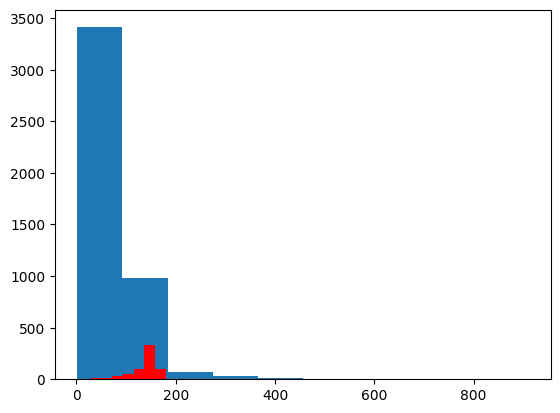

In [20]:
# Number of Characters
plt.hist(df[df['target'] == 0][['NO_Character']])
plt.hist(df[df['target'] == 1][['NO_Character']], color = 'r')
plt.show()

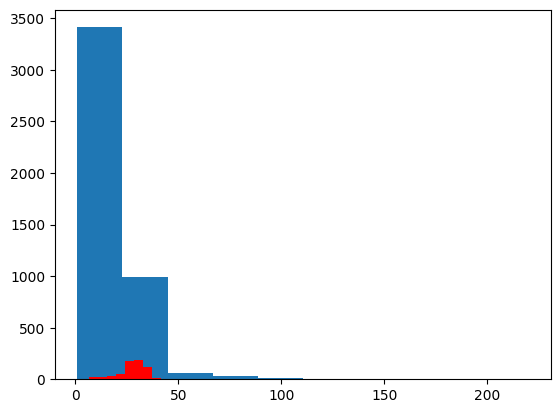

In [21]:
# Number of Words
plt.hist(df[df['target'] == 0][['NO_Words']])
plt.hist(df[df['target'] == 1][['NO_Words']], color = 'r')
plt.show()

In [22]:
df.corr()

C:\Users\Abhisek\AppData\Local\Temp\ipykernel_21492\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,target,NO_Character,NO_Words,NO_Sent
target,1.000000,0.374395,0.256038,0.281055
NO_Character,0.374395,1.000000,0.966163,0.636601
NO_Words,0.256038,0.966163,1.000000,0.683371
NO_Sent,0.281055,0.636601,0.683371,1.000000


## 3. Data Preprocessing
  Lower Case
  Tokenization
  Removing Special Characters
  Removing Stop Words and Punctiation
  Stemming

In [23]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " " .join(y)

In [24]:
ps = PorterStemmer()

In [25]:
transform_text("What you thinked about me. First time you saw me in class.")

'think first time saw class'

In [26]:
df['transformed_text'] = df['text'].apply(transform_text)

In [27]:
df.head()

,target,text,NO_Character,NO_Words,NO_Sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [28]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color='white')

In [29]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep = ' '))

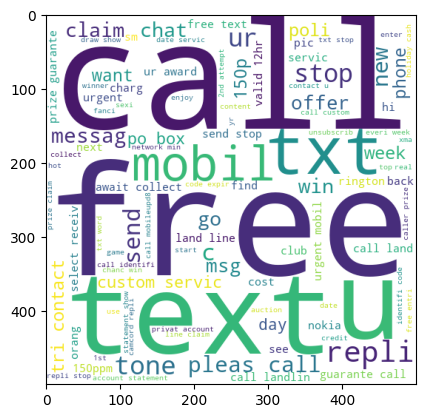

In [30]:
plt.imshow(spam_wc)
plt.show()

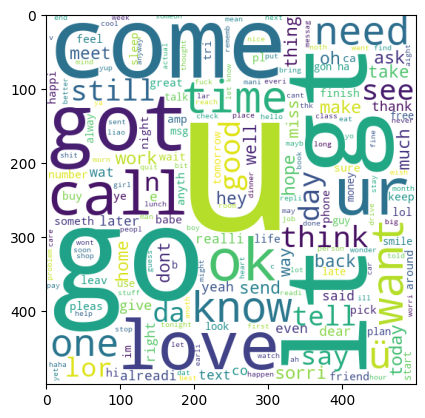

In [31]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep = ' '))
plt.imshow(ham_wc)
plt.show()

In [32]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for wrd in msg.split():
        spam_corpus.append(wrd)

In [33]:
len(spam_corpus)

9781

In [34]:
pd.DataFrame(Counter(spam_corpus).most_common(30))

,0,1
0,call,311
1,free,186
2,2,154
3,txt,139
4,text,122
5,ur,119
6,u,115
7,mobil,110
8,stop,108
9,repli,103


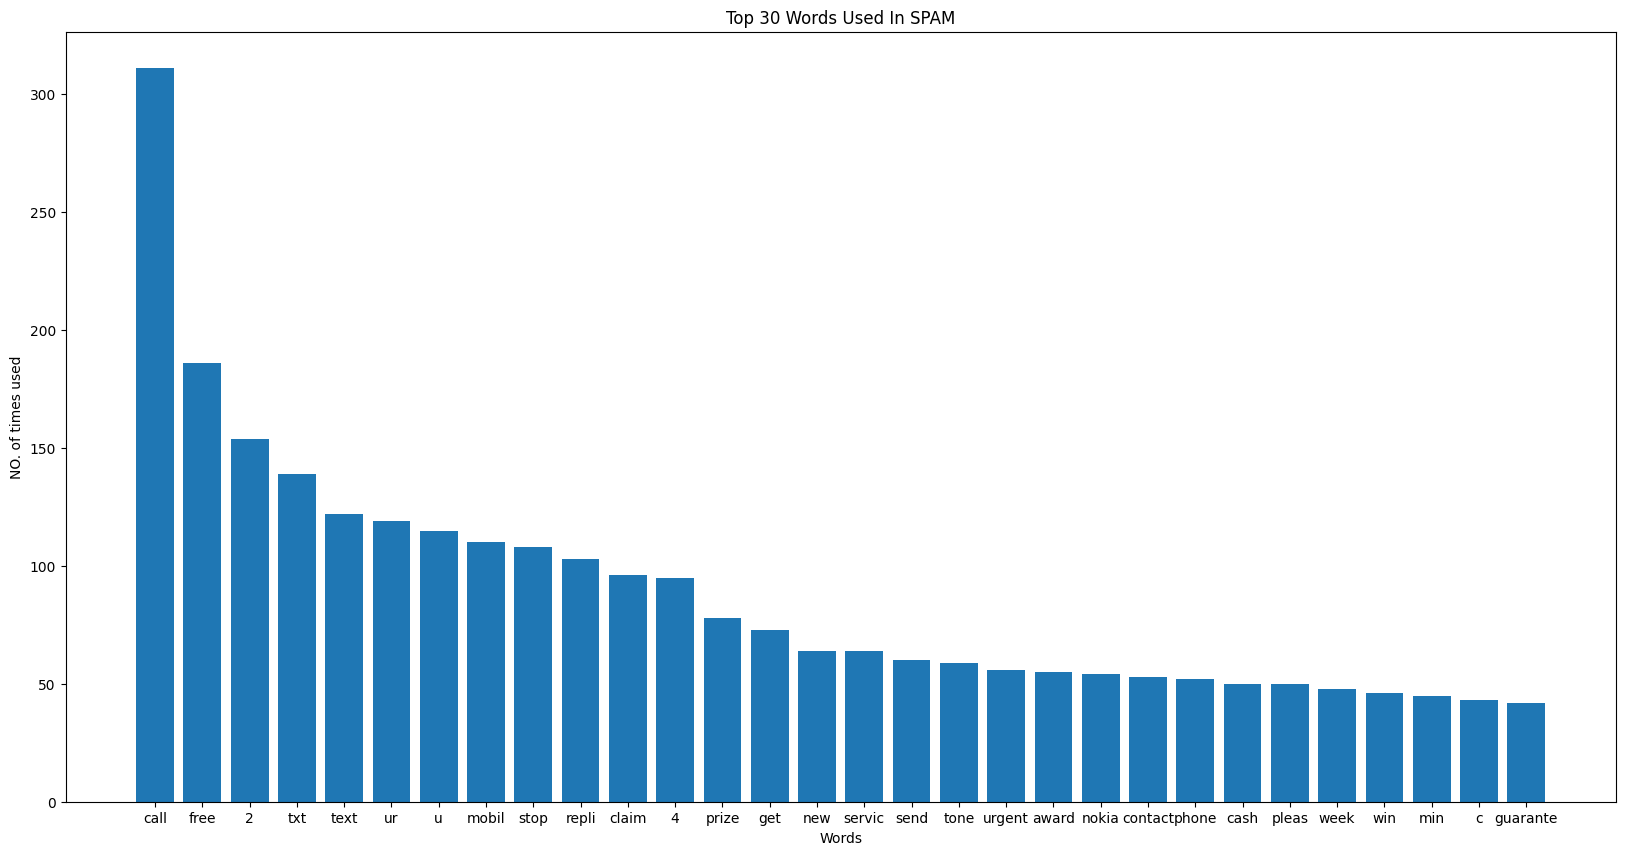

In [35]:
plt.figure(figsize=(20, 10))
plt.bar(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.title('Top 30 Words Used In SPAM')
plt.ylabel('NO. of times used')
plt.xlabel('Words')
plt.show()

In [36]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for wrd in msg.split():
        ham_corpus.append(wrd)
len(ham_corpus)

35930

In [37]:
pd.DataFrame(Counter(ham_corpus).most_common(30))

,0,1
0,u,897
1,go,407
2,get,351
3,2,288
4,gt,288
5,lt,287
6,come,278
7,got,239
8,know,237
9,like,236


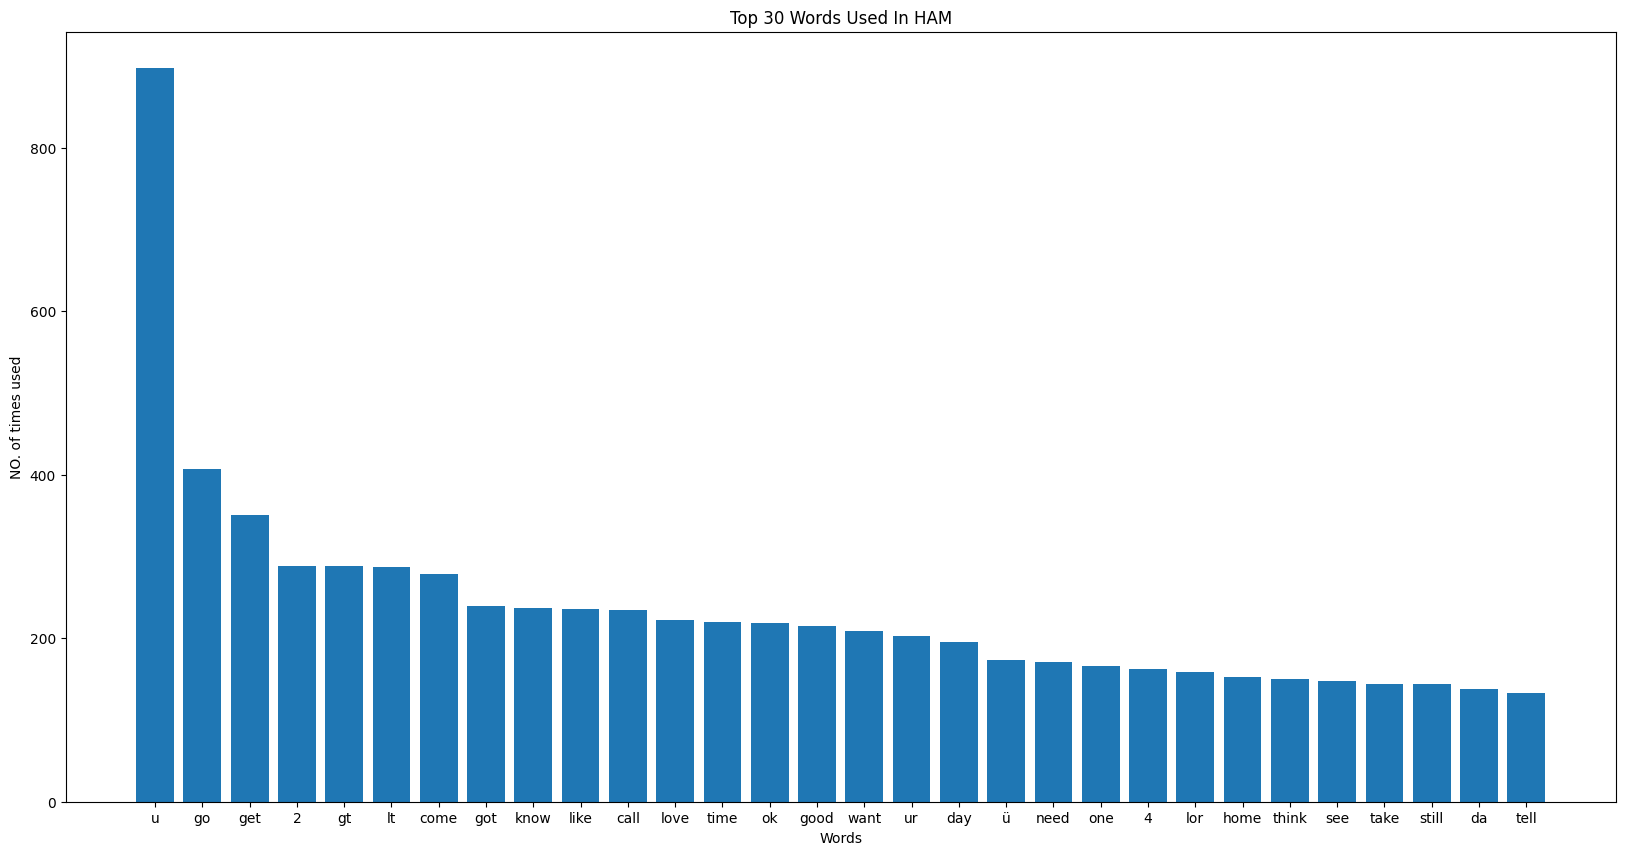

In [38]:
plt.figure(figsize=(20, 10))
plt.bar(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.title('Top 30 Words Used In HAM')
plt.ylabel('NO. of times used')
plt.xlabel('Words')
plt.show()

## 4. Model Building

In [39]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [40]:
X.shape

(5157, 3000)

In [41]:
y = df['target'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

In [43]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [44]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Confussion Matrix:", confusion_matrix(y_test, y_pred1))
print("Precision Score:", precision_score(y_test, y_pred1))

Accuracy: 0.8662790697674418
Confussion Matrix: [[784 121]
 [ 17 110]]
Precision Score: 0.47619047619047616


In [45]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("Confussion Matrix:", confusion_matrix(y_test, y_pred3))
print("Precision Score:", precision_score(y_test, y_pred3))

Accuracy: 0.9835271317829457
Confussion Matrix: [[903   2]
 [ 15 112]]
Precision Score: 0.9824561403508771


In [46]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Confussion Matrix:", confusion_matrix(y_test, y_pred2))
print("Precision Score:", precision_score(y_test, y_pred2))

Accuracy: 0.9709302325581395
Confussion Matrix: [[905   0]
 [ 30  97]]
Precision Score: 1.0


## Here MultinomialNB Algorithm Works Very Good With Precision Score of 100%

### Model Dumping

In [47]:
#pickle.dump(tfidf, open("vectorizer.pkl", 'wb'))
#pickle.dump(mnb, open('model.pkl', 'wb'))